In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline

## K-Means Clustering

In [2]:
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m):
        min_dist = 100000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j, :])**2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    return idx

Let's test the function to make sure it's working as expected. We'll use the test case provided in the exercise.

In [3]:
data = loadmat('data/ex7data2.mat')
X = data['X']
initial_centroids = np.array([[3,3], [6,2], [8,5]])

In [4]:
idx = find_closest_centroids(X,initial_centroids)

In [5]:
idx[0:3]

array([ 0.,  2.,  1.])

The output matches the expected values in the text (remember our arrays are zero-indexed instead of one-indexed so the values are one lower than in the exercise). Next we need a function to compute the centroid of a cluster. The centroid is simply the mean of all of the examples currently assigned to the cluster.

In [6]:
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k,n))
    
    for i in range(k):
        indices = np.where(idx == i )
        centroids[i, :] = (np.sum(X[indices,:], axis =1) / len(indices[0])).ravel()
        
    return centroids

In [7]:
compute_centroids(X, idx, 3)

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

This output also matches the expected values from the exercise. So far so good. The next part involves actually running the algorithm for some number of iterations and visualizing the result. This step was implmented for us in the exercise, but since it's not that complicated I'll build it here from scratch. In order to run the algorithm we just need to alternate between assigning examples to the nearest cluster and re-computing the cluster centroids.

In [8]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
        
    return idx, centroids

In [9]:
idx, centroids = run_k_means(X,initial_centroids, 10)

We can now plot the result using color coding to indicate cluster membership.

In [10]:
cluster1 = X[np.where(idx==0)[0], :]
cluster2 = X[np.where(idx==1)[0], :]
cluster3 = X[np.where(idx==2)[0], :]

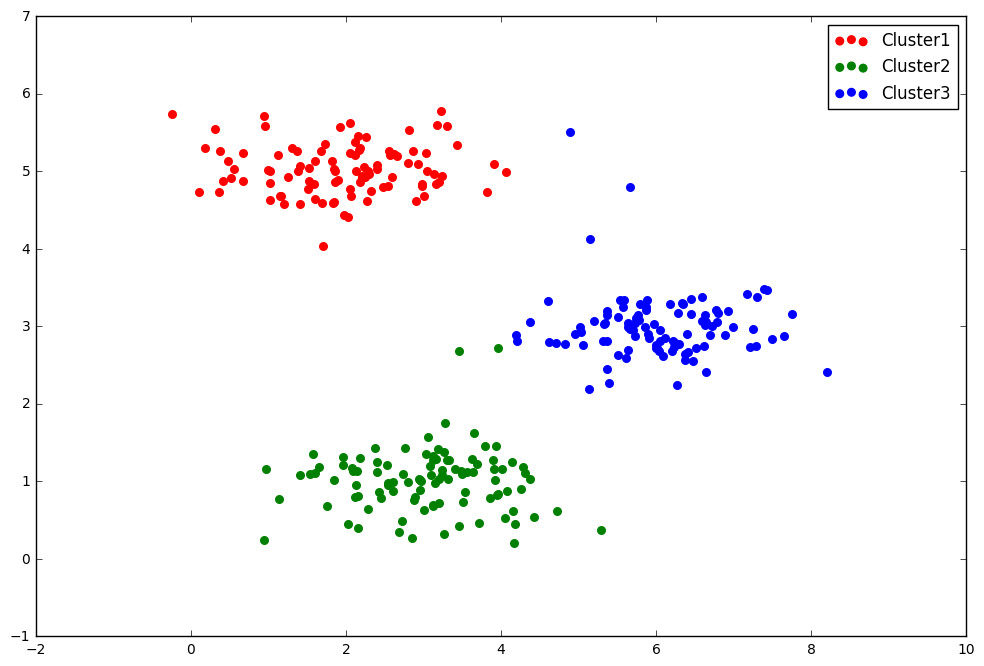

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster3')
ax.legend()
plt.show()

One step we skipped over is a process for initializing the centroids. This can affect the convergence of the algorithm. We're tasked with creating a function that selects random examples and uses them as the initial centroids.

In [12]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i,:] = X[idx[i],:]
        
    return centroids

In [13]:
init_centroids(X,3)

array([[ 5.50258659,  3.11869075],
       [ 3.31058167,  1.03124461],
       [ 1.30882588,  5.30158701]])

Our next task is to apply K-means to image compression. The intuition here is that we can use clustering to find a small number of colors that are most representative of the image, and map the original 24-bit colors to a lower-dimensional color space using the cluster assignments.

In [14]:
image_data = loadmat('data/bird_small.mat')

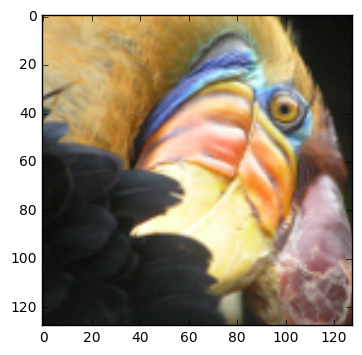

In [15]:
plt.imshow(image_data['A'])
plt.show()

In [16]:
image_data

{'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ..., 
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ..., 
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ..., 
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ..., 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ..., 
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ..., 
         [ 80,  38,  40],
         [ 68,  39,  40],
         [ 59,  43,  42]],
 
        [[ 15,  19,  19],
         [ 20,  20,  18],
         [ 18,  19,  17],
         ..., 
         [ 65,  43

We can quickly look at the shape of the data to validate that it looks like what we'd expect for an image.

In [17]:
A = image_data['A']
A.shape

(128, 128, 3)

Now we need to apply some pre-processing to the data and feed it into the K-means algorithm.

In [18]:
# normalise value ranges
A = A/255

In [19]:
# reshape the arrry
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))

In [20]:
# randomly initialise the centroids
initial_centroids = init_centroids(X,16)

In [21]:
#run the algorithm
idx, centroids = run_k_means(X,initial_centroids, 10)

In [22]:
#get the closest centroids one last time
idx = find_closest_centroids(X,centroids)

In [23]:
#map each pixel to the centroid value
X_recovered = centroids[idx.astype(int), :]

In [24]:
#reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))

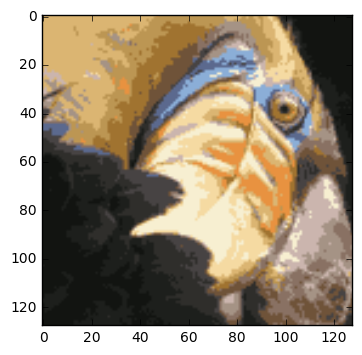

In [25]:
plt.imshow(X_recovered)
plt.show()

You can see that we created some artifacts in the compression but the main features of the image are still there despite mapping the original image to only 16 colors. That's it for K-means. We'll now move on to principal component analysis.

## Principal Component Analysis

PCA is a linear transformation that finds the "principal components", or directions of greatest variance, in a data set. It can be used for dimension reduction among other things. In this exercise we're first tasked with implementing PCA and applying it to a simple 2-dimensional data set to see how it works. Let's start off by loading and visualizing the data set.

In [26]:
data = loadmat('data/ex7data1.mat')

In [27]:
X = data['X']

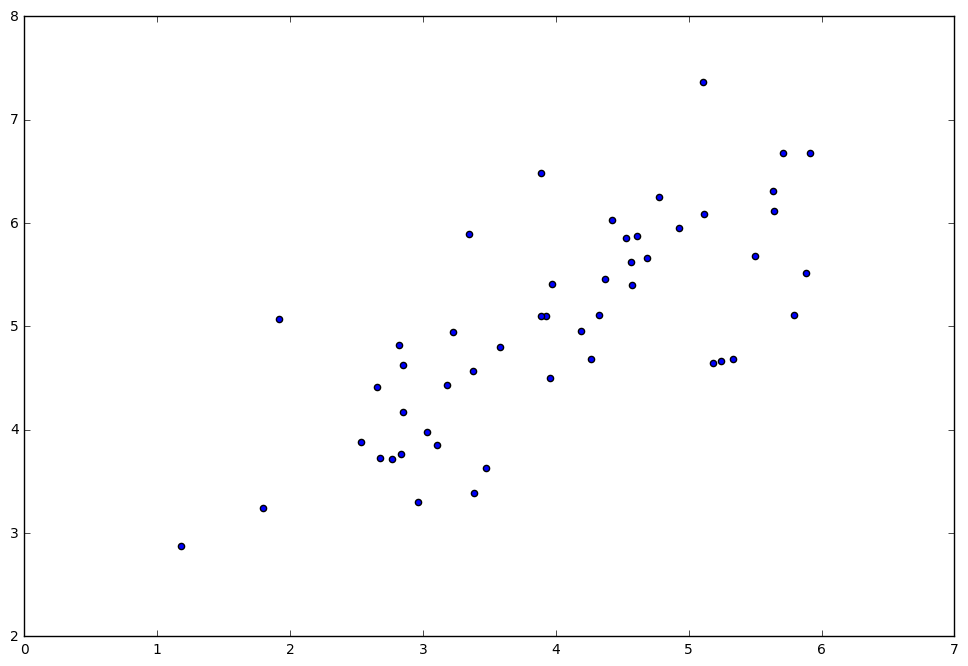

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

The algorithm for PCA is fairly simple. After ensuring that the data is normalized, the output is simply the singular value decomposition of the covariance matrix of the original data. Since numpy already has built-in functions to calculate the covariance and SVD of a matrix, we'll use those rather than build from scratch.

In [33]:
def pca(X):
    #normalise
    X = (X-X.mean()) / X.std()
    
    #covariance matrix
    X = np.matrix(X)
    cov = (X.T * X) / X.shape[0]
    
    #SVD
    
    U,S,V = np.linalg.svd(cov)
    
    return U,S,V

In [34]:
U,S,V = pca(X)

In [35]:
U,S,V

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([ 1.43584536,  0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

Now that we have the principal components (matrix U), we can use these to project the original data into a lower-dimensional space. For this task we'll implement a function that computes the projection and selects only the top K components, effectively reducing the number of dimensions.

In [36]:
def project_data(X,U,k):
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

In [37]:
Z = project_data(X,U,1)

In [38]:
Z

matrix([[-4.74689738],
        [-7.15889408],
        [-4.79563345],
        [-4.45754509],
        [-4.80263579],
        [-7.04081342],
        [-4.97025076],
        [-8.75934561],
        [-6.2232703 ],
        [-7.04497331],
        [-6.91702866],
        [-6.79543508],
        [-6.3438312 ],
        [-6.99891495],
        [-4.54558119],
        [-8.31574426],
        [-7.16920841],
        [-5.08083842],
        [-8.54077427],
        [-6.94102769],
        [-8.5978815 ],
        [-5.76620067],
        [-8.2020797 ],
        [-6.23890078],
        [-4.37943868],
        [-5.56947441],
        [-7.53865023],
        [-7.70645413],
        [-5.17158343],
        [-6.19268884],
        [-6.24385246],
        [-8.02715303],
        [-4.81235176],
        [-7.07993347],
        [-5.45953289],
        [-7.60014707],
        [-4.39612191],
        [-7.82288033],
        [-3.40498213],
        [-6.54290343],
        [-7.17879573],
        [-5.22572421],
        [-4.83081168],
        [-7

We can also attempt to recover the original data by reversing the steps we took to project it.

In [44]:
def recover_data(Z,U,k):
    U_reduced = U[:,:k]
    return np.dot(Z,U_reduced.T)

In [45]:
X_recovered = recover_data(Z,U,1)

In [46]:
X_recovered

matrix([[ 3.76152442,  2.89550838],
        [ 5.67283275,  4.36677606],
        [ 3.80014373,  2.92523637],
        [ 3.53223661,  2.71900952],
        [ 3.80569251,  2.92950765],
        [ 5.57926356,  4.29474931],
        [ 3.93851354,  3.03174929],
        [ 6.94105849,  5.3430181 ],
        [ 4.93142811,  3.79606507],
        [ 5.58255993,  4.29728676],
        [ 5.48117436,  4.21924319],
        [ 5.38482148,  4.14507365],
        [ 5.02696267,  3.8696047 ],
        [ 5.54606249,  4.26919213],
        [ 3.60199795,  2.77270971],
        [ 6.58954104,  5.07243054],
        [ 5.681006  ,  4.37306758],
        [ 4.02614513,  3.09920545],
        [ 6.76785875,  5.20969415],
        [ 5.50019161,  4.2338821 ],
        [ 6.81311151,  5.24452836],
        [ 4.56923815,  3.51726213],
        [ 6.49947125,  5.00309752],
        [ 4.94381398,  3.80559934],
        [ 3.47034372,  2.67136624],
        [ 4.41334883,  3.39726321],
        [ 5.97375815,  4.59841938],
        [ 6.10672889,  4.700

f we then attempt to visualize the recovered data, the intuition behind how the algorithm works becomes really obvious.

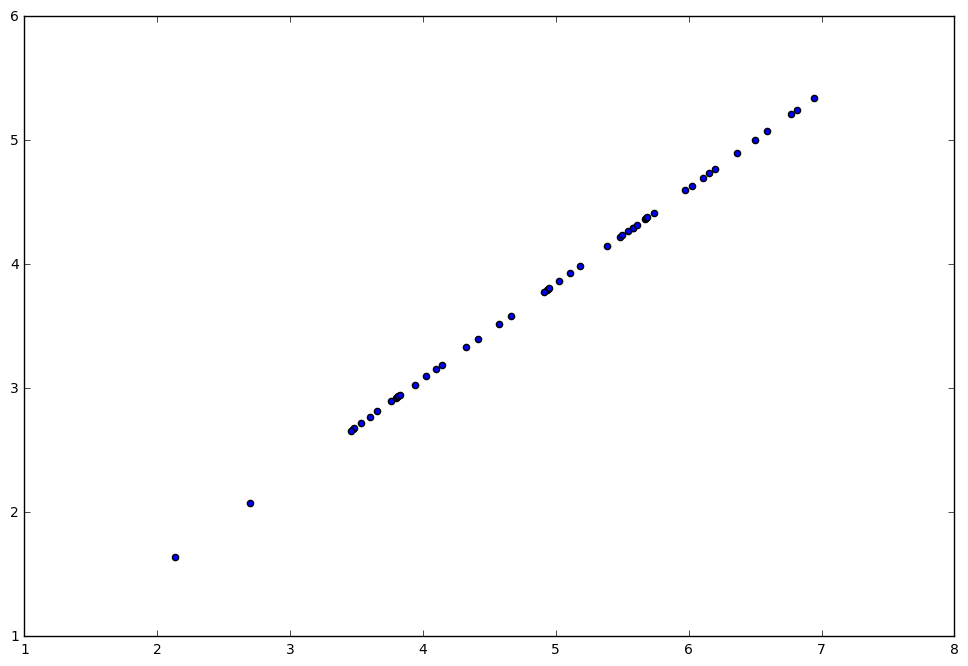

In [51]:
fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter([X_recovered[:, 0]], [X_recovered[:, 1]])
plt.show()

Notice how the points all seem to be compressed down to an invisible line. That invisible line is essentially the first principal component. The second principal component, which we cut off when we reduced the data to one dimension, can be thought of as the variation orthogonal to that line. Since we lost that information, our reconstruction can only place the points relative to the first principal component.

Our last task in this exercise is to apply PCA to images of faces. By using the same dimension reduction techniques we can capture the "essence" of the images using much less data than the original images.

In [52]:
faces = loadmat('data/ex7faces.mat')

In [53]:
X = faces['X']
X.shape

(5000, 1024)

The exercise code includes a function that will render the first 100 faces in the data set in a grid. Rather than try to re-produce that here, you can look in the exercise text for an example of what they look like. We can at least render one image fairly easily though.

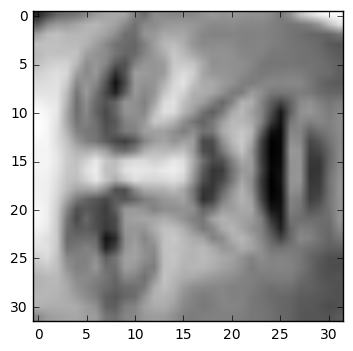

In [59]:
face = np.reshape(X[3,:], (32, 32))  
plt.imshow(face, cmap='gray')
plt.show()

Yikes, that looks awful! These are only 32 x 32 grayscale images though (it's also rendering sideways, but we can ignore that for now). Our next step is to run PCA on the faces data set and take the top 100 principal components.

In [56]:
U,S,V = pca(X)
Z = project_data(X,U,100)

Now we can attempt to recover the original structure and render it again.

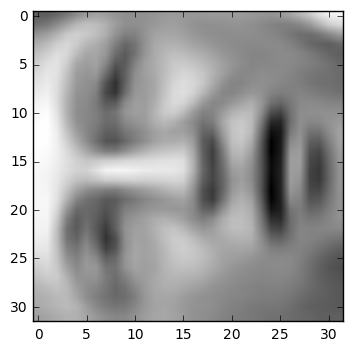

In [61]:
X_recovered = recover_data(Z, U, 100)  
face = np.reshape(X_recovered[3,:], (32, 32))  
plt.imshow(face, cmap='gray')
plt.show()

Notice that we lost some detail, though not as much as you might expect for a 10x reduction in the number of dimensions.

That concludes exercise 7!